### Project

In [1]:
# --- Imports ---
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

# Enable parallel chains
numpyro.set_host_device_count(4)


#### Load Data

In [2]:
# --- Load Data ---
df = pd.read_csv('component-data-2c.csv')

t = df['day'].values                # shape (N_obs,)
y = df['integrity'].values          # shape (N_obs,)
idx = df['index'].astype(int).values  # component index in [0..74]
X = df[['X1','X2','X3','X4','X5']].values  # shape (N_obs, 5)
N_comp = df['index'].nunique()      # should be 75


### Define Models

In [3]:
# --- Model Definitions ---
def baseline_model(t, y, idx, N_comp):
    # Hyper-priors for population intercept u and decay rate v
    mu_u    = numpyro.sample("mu_u",    dist.Normal(90, 10))
    sigma_u = numpyro.sample("sigma_u", dist.HalfNormal(10))
    mu_v    = numpyro.sample("mu_v",    dist.Normal(5, 2))
    sigma_v = numpyro.sample("sigma_v", dist.HalfNormal(2))
    # Component-level u_i, v_i
    with numpyro.plate("components", N_comp):
        u = numpyro.sample("u", dist.Normal(mu_u, sigma_u))
        v = numpyro.sample("v", dist.Normal(mu_v, sigma_v))
    # Observation noise
    sigma_y = numpyro.sample("sigma_y", dist.HalfNormal(10))
    # Expected integrity
    u_i = u[idx]
    v_i = v[idx]
    mu  = u_i * jnp.exp(-v_i * t / 100.0)
    # Likelihood
    numpyro.sample("obs", dist.Normal(mu, sigma_y), obs=y)


def enhanced_model(t, y, idx, X, N_comp):
    # Hyper-priors for population intercept u and decay rate v
    mu_u    = numpyro.sample("mu_u",    dist.Normal(90, 10))
    sigma_u = numpyro.sample("sigma_u", dist.HalfNormal(10))
    mu_v    = numpyro.sample("mu_v",    dist.Normal(5, 2))
    sigma_v = numpyro.sample("sigma_v", dist.HalfNormal(2))
    # Component-level u_i, v_i
    with numpyro.plate("components", N_comp):
        u = numpyro.sample("u", dist.Normal(mu_u, sigma_u))
        v = numpyro.sample("v", dist.Normal(mu_v, sigma_v))
    # Diagnostic weights
    sigma_w = numpyro.sample("sigma_w", dist.HalfNormal(1.0))
    w       = numpyro.sample("w", dist.Normal(0, sigma_w)
                                    .expand([X.shape[1]]).to_event(1))
    # Observation noise
    sigma_y = numpyro.sample("sigma_y", dist.HalfNormal(10))
    # Expected integrity with diagnostics
    u_i  = u[idx]
    v_i  = v[idx]
        # Compute influence: X per observation is constant per component
    infl = (X * w).sum(axis=1)
    mu   = u_i * jnp.exp(-(v_i + infl) * t / 100.0)
    # Likelihood
    numpyro.sample("obs", dist.Normal(mu, sigma_y), obs=y)

### Render models as PGM

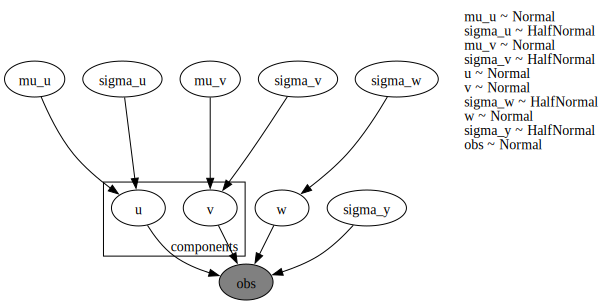

In [4]:
#numpyro.render_model(
    #baseline_model,
    #model_args=(t, y, idx, N_comp),
    #render_distributions=True,
    #render_params=True
#)

numpyro.render_model(
    enhanced_model,
    model_args=(t, y, idx, X, N_comp),
    render_distributions=True,
    render_params=True
)

### Run HMC/NUTS on both models

In [5]:
# --- Run MCMC for Baseline ---
# Fix random seed for reproducibility
rng_key = jax.random.PRNGKey(0)
num_warmup, num_samples = 2000, 2000

def fit(model, args):
    kernel = NUTS(model)
    mcmc   = MCMC(kernel,
                  num_warmup=num_warmup,
                  num_samples=num_samples,
                  num_chains=4)
    mcmc.run(rng_key, *args)
    mcmc.print_summary()
    return mcmc

print("Fitting baseline model...")
mcmc_baseline = fit(baseline_model, (t, y, idx, N_comp))

print("Fitting enhanced model...")
mcmc_enhanced = fit(enhanced_model, (t, y, idx, X, N_comp))



Fitting baseline model...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_u     89.74      0.90     89.75     88.30     91.23   7672.75      1.00
      mu_v      3.94      0.22      3.93      3.59      4.29   9150.25      1.00
   sigma_u      5.27      0.81      5.24      3.92      6.55   3760.75      1.00
   sigma_v      1.58      0.17      1.57      1.31      1.85   7909.16      1.00
   sigma_y      5.10      0.13      5.10      4.88      5.32   9933.70      1.00
      u[0]     93.98      2.21     93.95     90.39     97.60  14877.96      1.00
      u[1]     87.39      4.47     87.43     79.83     94.50  13567.20      1.00
      u[2]     98.53      2.21     98.49     95.05    102.28  12550.21      1.00
      u[3]     89.31      2.10     89.29     85.85     92.80  14135.56      1.00
      u[4]     87.10      3.90     87.16     80.73     93.54  13362.88      1.00
      u[5]     89.40      4.10     89.38     82.74     96.09  13056.06      1.00
      u[6]     91.71      3

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_u     90.36      0.77     90.35     89.12     91.66   5936.96      1.00
      mu_v      2.02      0.15      2.02      1.77      2.27    714.91      1.00
   sigma_u      4.78      0.62      4.75      3.79      5.78   3893.95      1.00
   sigma_v      0.35      0.07      0.34      0.25      0.46   1546.50      1.00
   sigma_w      0.62      0.23      0.57      0.30      0.95   8429.75      1.00
   sigma_y      5.09      0.13      5.08      4.88      5.29  12750.76      1.00
      u[0]     94.25      2.20     94.22     90.77     97.99  12226.19      1.00
      u[1]     91.70      3.73     91.71     85.71     97.88   9791.66      1.00
      u[2]     98.46      2.08     98.45     95.24    102.04  11220.90      1.00
      u[3]     89.36      2.06     89.35     85.98     92.74  14137.97      1.00
      u[4]     89.67      3.25     89.67     84.42     95.05  12705.66      1.00
      u[5]     88.17      3

### Diagnostic trace plots 

Text(0.5, 1.02, 'Enhanced Model Trace & Marginals')

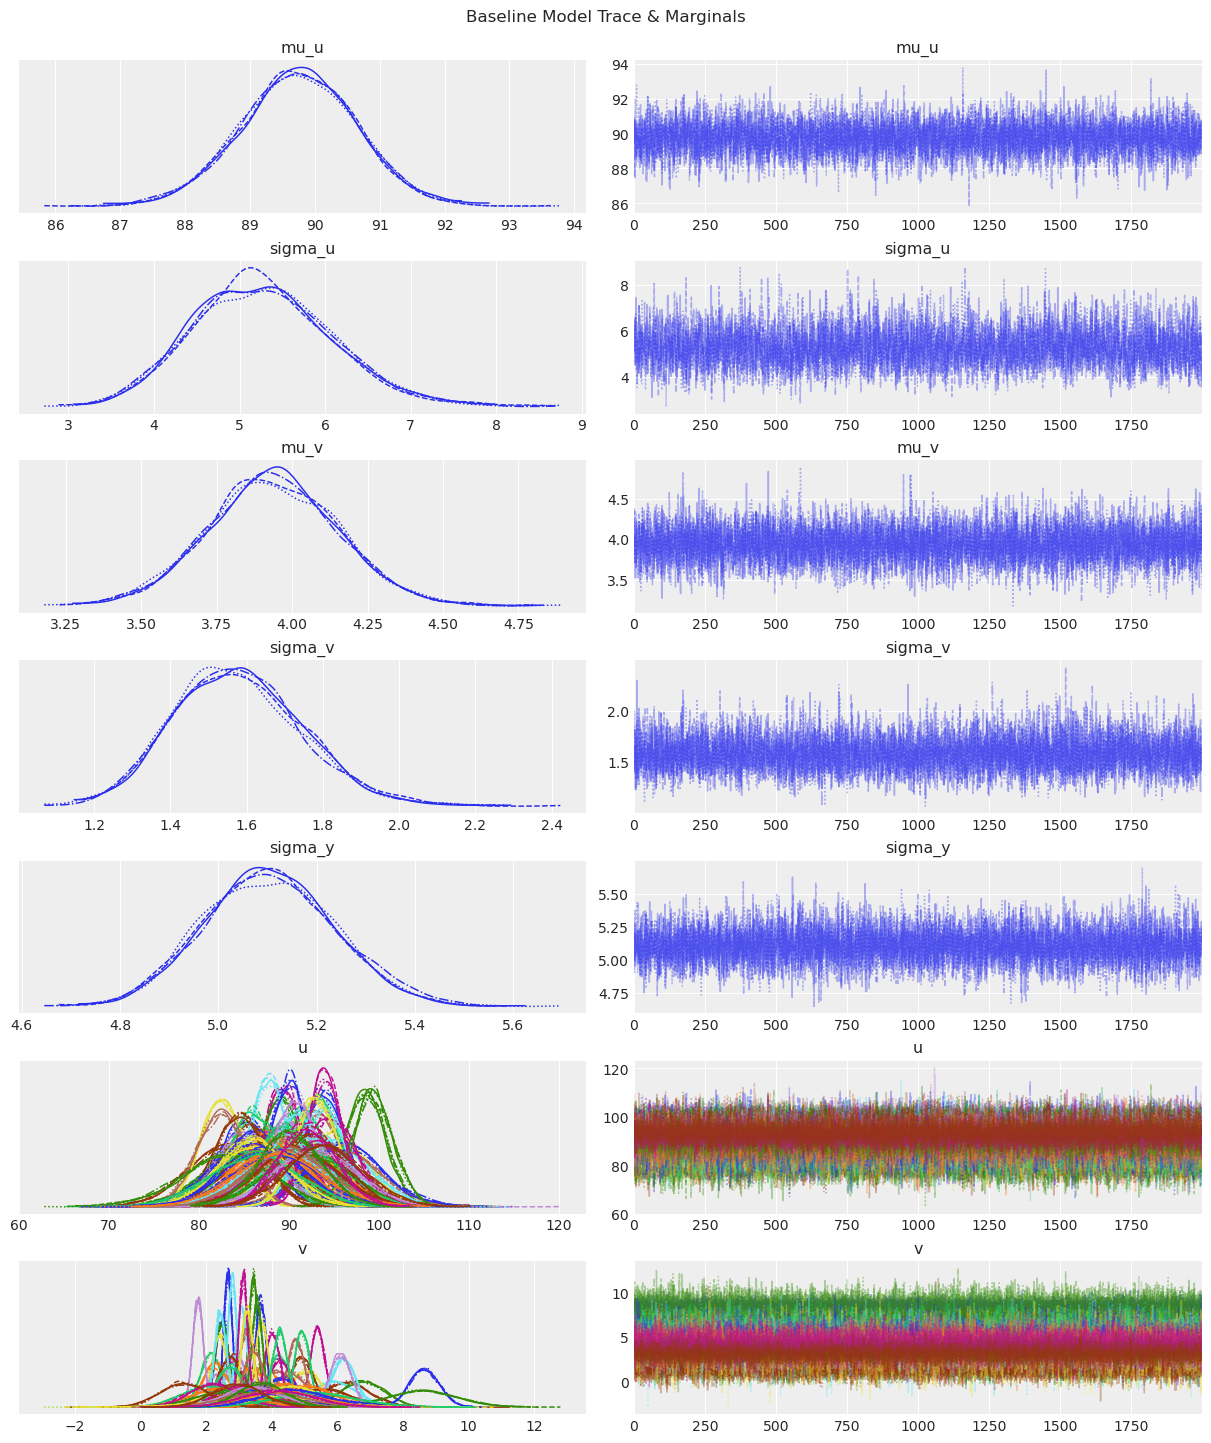

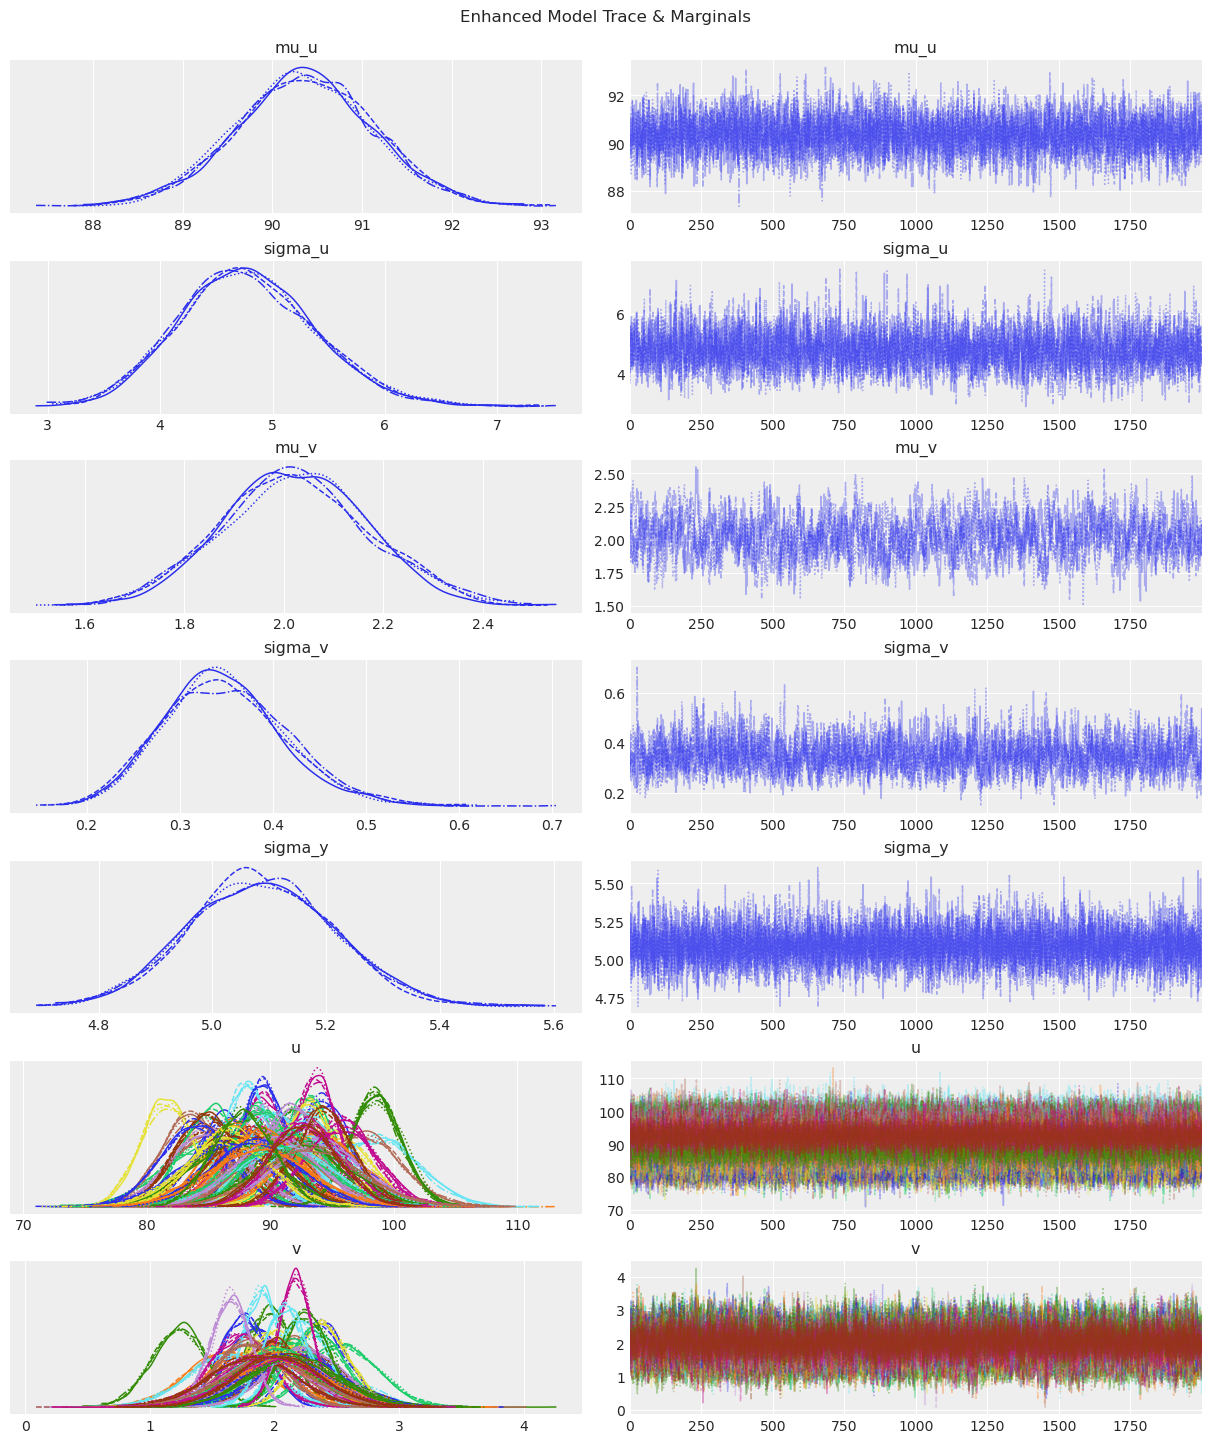

In [6]:
az.style.use("arviz-darkgrid")

# Convert MCMC to an ArviZ InferenceData
idata_bl = az.from_numpyro(mcmc_baseline)
az.plot_trace(
    idata_bl,
    var_names=["mu_u","sigma_u","mu_v","sigma_v","sigma_y","u","v"],
    compact=True
)
plt.suptitle("Baseline Model Trace & Marginals", y=1.02)


idata_en = az.from_numpyro(mcmc_enhanced)
az.plot_trace(
    idata_en,
    var_names=["mu_u","sigma_u","mu_v","sigma_v","sigma_y","u","v"],
    compact=True
)
plt.suptitle("Enhanced Model Trace & Marginals", y=1.02)

### Extract posterior and build Predictive for later use  

In [7]:
# Extract posterior samples for enhanced model
posterior = mcmc_enhanced.get_samples()

# Build Predictive for later use
predictive = Predictive(
    enhanced_model,
    posterior_samples=posterior,
    return_sites=["obs"]
)

### Illustrations  of the model fit for four individual components 

Baseline model fits:


/var/folders/rb/lxr03kys11b6_p3fgyvd1x340000gn/T/ipykernel_94179/4164615139.py:34: UserWarning: The figure layout has changed to tight
  plt.legend(fontsize=8); plt.tight_layout()


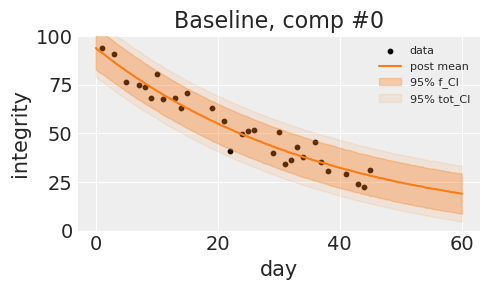

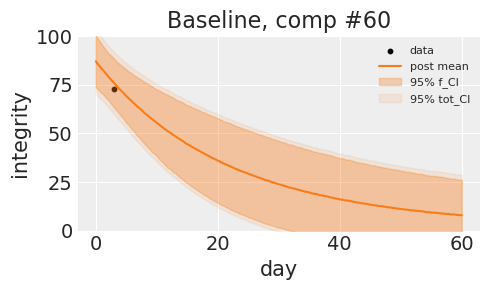

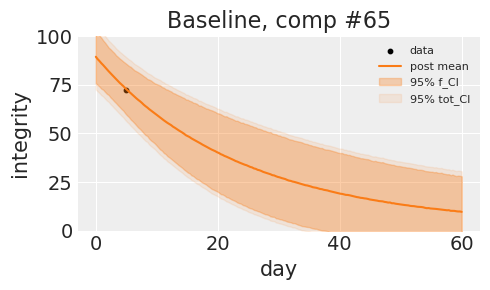

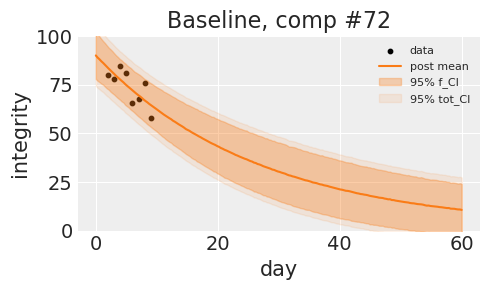

Enhanced model fits:


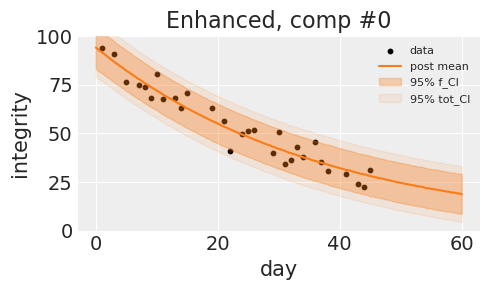

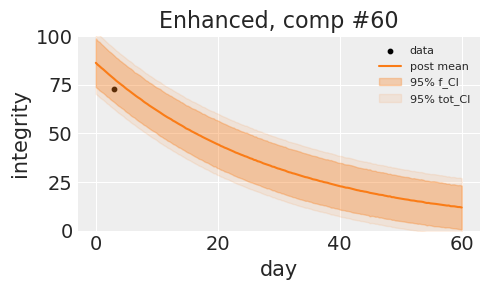

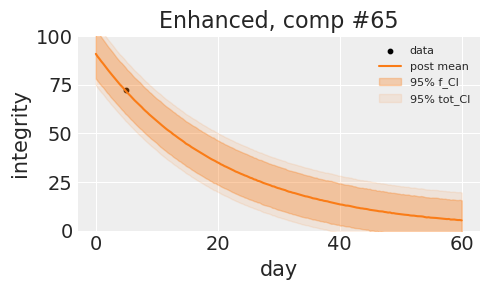

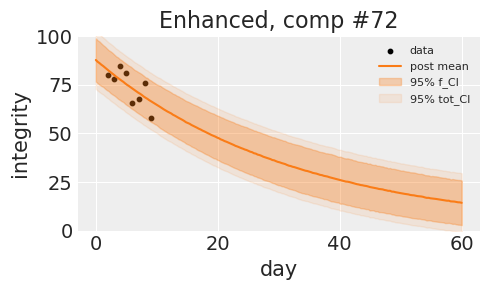

In [8]:
# --- Illustrations of Model Fit for Four Components ---
examples = [0, 60, 65, 72]        # one well-observed (0), three sparse

t_pred = jnp.linspace(0, 60, 200)

def plot_post_pred(model, samples, title):
    pred = Predictive(model, samples, return_sites=["obs"])
    for ex in examples:
        # prepare inputs for Predictive: replicate ex across t_pred
        if model is baseline_model:
            args = (t_pred, None, jnp.repeat(ex, len(t_pred)), N_comp)
        else:
            X_pred = jnp.tile(X[idx == ex][:1], (len(t_pred), 1))
            args   = (t_pred, None, jnp.repeat(ex, len(t_pred)), X_pred, N_comp)

        y_preds = pred(rng_key, *args)["obs"]  # (chains×samples, len(t_pred))
        mean    = y_preds.mean(0)
        std_f   = y_preds.std(0)
        # total std = sqrt(f-std² + sigma_y²)
        sigma_y_val = samples["sigma_y"][:, None].mean(0)
        std_y   = jnp.sqrt(std_f**2 + sigma_y_val**2)

        # plot
        plt.figure(figsize=(5, 3))
        mask = idx == ex
        plt.scatter(t[mask], y[mask], c="black", s=10, label="data")
        plt.plot(t_pred, mean, c="C1", label="post mean")
        plt.fill_between(t_pred, mean - 1.96 * std_f, mean + 1.96 * std_f,
                         color="C1", alpha=0.3, label="95% f_CI")
        plt.fill_between(t_pred, mean - 1.96 * std_y, mean + 1.96 * std_y,
                         color="C1", alpha=0.1, label="95% tot_CI")
        plt.title(f"{title}, comp #{ex}")
        plt.xlabel("day"); plt.ylabel("integrity"); plt.ylim(0, 100)
        plt.legend(fontsize=8); plt.tight_layout()
        plt.show()

print("Baseline model fits:")
plot_post_pred(baseline_model, mcmc_baseline.get_samples(), "Baseline")
print("Enhanced model fits:")
plot_post_pred(enhanced_model, mcmc_enhanced.get_samples(), "Enhanced")


### Trace and Marginal plots for the weight parameters wj and any associated hyper parameters

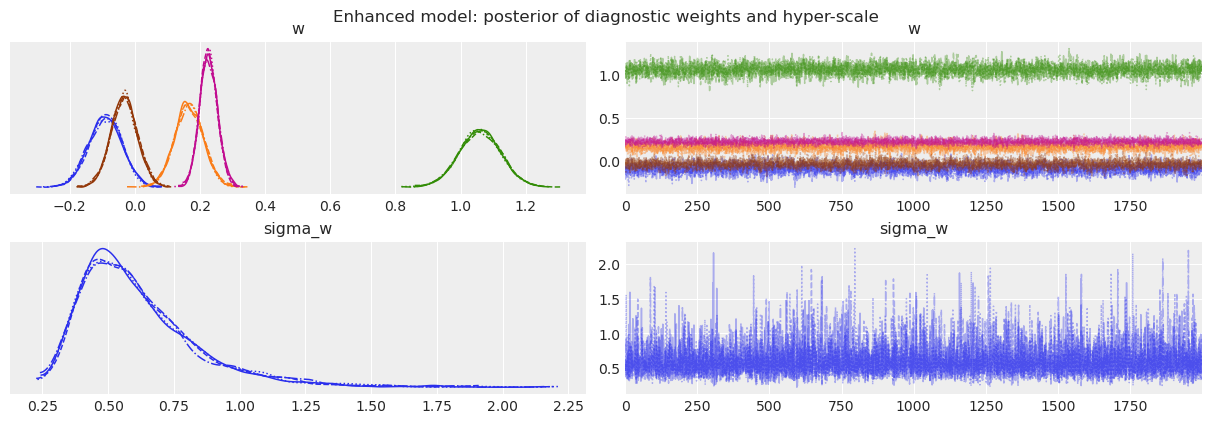

95% HDIs for diagnostic weights (w_j): <xarray.DataArray 'w' (w_dim_0: 5, hdi: 2)>
array([[-0.19335645,  0.00476824],
       [ 0.08074889,  0.25346375],
       [ 0.9413119 ,  1.1934185 ],
       [ 0.17236675,  0.2806569 ],
       [-0.11088876,  0.04866118]])
Coordinates:
  * w_dim_0  (w_dim_0) int64 0 1 2 3 4
  * hdi      (hdi) <U6 'lower' 'higher'


In [9]:
# --- Enhanced Model Weights Trace & HDI ---
# Bundle posterior into InferenceData
idata_enhanced = az.from_numpyro(mcmc_enhanced)

# Plot only diagnostic weights and their hyper-scale
az.plot_trace(
    idata_enhanced,
    var_names=["w", "sigma_w"],
    compact=True
)
plt.suptitle("Enhanced model: posterior of diagnostic weights and hyper-scale", y=1.02)
plt.show()

# Compute 95% HDI for each weight w_j
hdis = az.hdi(idata_enhanced, var_names="w", hdi_prob=0.95)["w"]
print("95% HDIs for diagnostic weights (w_j):", hdis)

### Blind test predictions

In [10]:
# Use existing DataFrame `df`, `predictive`, and `rng_key`
blind_idxs = list(range(50, 75))
results = []
for i in blind_idxs:
    g = df[df['index'] == i]
    ID = g['ID'].iloc[0]
    # Diagnostics X1–X5 (constant within each component)
    X_diag = jnp.array(g[['X1','X2','X3','X4','X5']].iloc[0].values).reshape(1, -1)
    # Posterior-predictive draws at t = 30
    t30 = jnp.array([30.0]); idx30 = jnp.array([i])
    draws = predictive(
        rng_key,
        t=t30,
        y=None,
        idx=idx30,
        X=X_diag,
        N_comp=N_comp
    )['obs'][:, 0]
    # Compute P(y ≤ 30)
    p_leq_30 = float(jnp.mean(draws <= 30.0))
    results.append({'ID': ID, 'index': i, 'probability': p_leq_30})
# Save results
df_pred = pd.DataFrame(results)
df_pred.to_csv('predictions.csv', index=False, float_format='%.6f')
print(df_pred)


        ID  index  probability
0   K#0050     50     0.263500
1   K#0051     51     0.993875
2   K#0052     52     1.000000
3   K#0053     53     0.456375
4   K#0054     54     0.041125
5   K#0055     55     0.753375
6   K#0056     56     0.939375
7   K#0057     57     0.002000
8   K#0058     58     0.998875
9   K#0059     59     0.542000
10  K#0060     60     0.384125
11  K#0061     61     0.039375
12  K#0062     62     0.137000
13  K#0063     63     0.044625
14  K#0064     64     0.000125
15  K#0065     65     0.920500
16  K#0066     66     0.999500
17  K#0067     67     1.000000
18  K#0068     68     0.088000
19  K#0069     69     0.990375
20  K#0070     70     0.906750
21  K#0071     71     0.772375
22  K#0072     72     0.194000
23  K#0073     73     0.854750
24  K#0074     74     0.022625


### Black box model comparison

/var/folders/rb/lxr03kys11b6_p3fgyvd1x340000gn/T/ipykernel_94179/3100377608.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0,0,1,0.9])


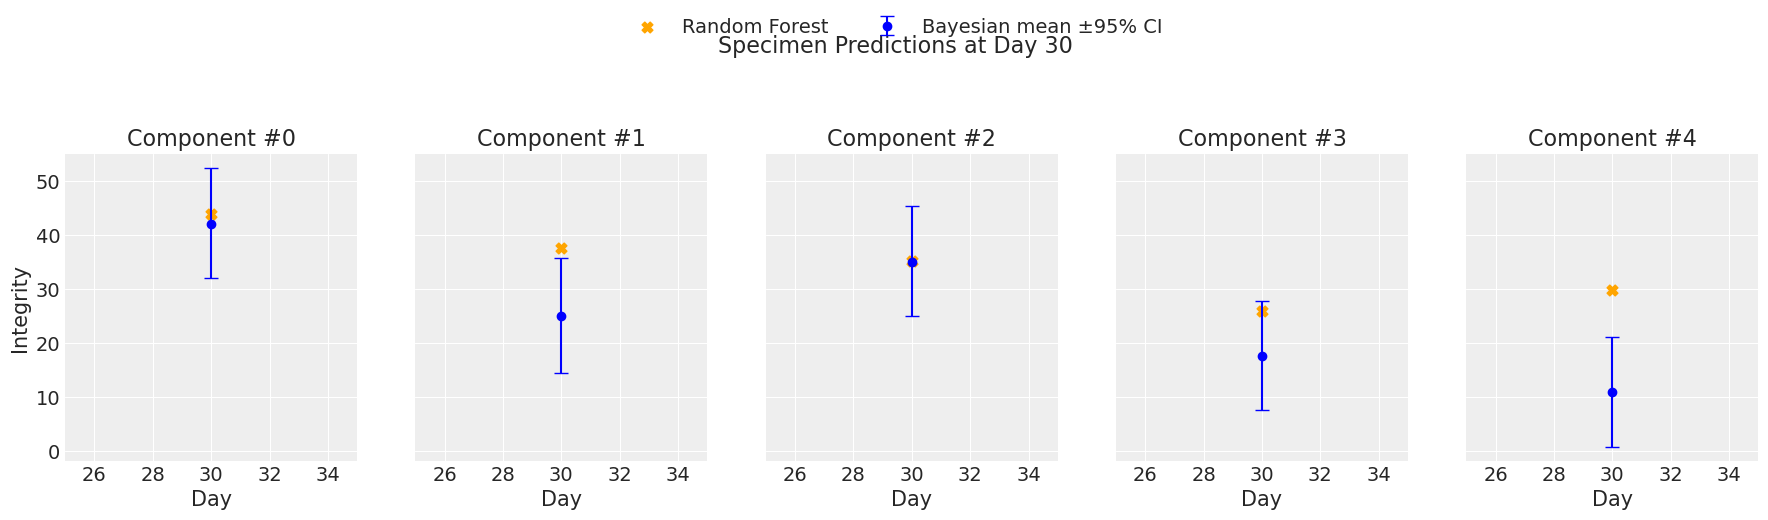

In [11]:
# --- Black-Box Model Comparison ---
import numpy as np
from sklearn.ensemble import RandomForestRegressor  # or your chosen black-box

# Prepare features for black-box: derive summary stats up to t=10
# Here: average integrity in 0-10 days, average gradient
features = []
targets = []
for comp_id in range(N_comp):
    comp = df[df['index'] == comp_id]
    obs = comp[comp['day'] <= 10]
    if len(obs) >= 2:
        t_vals = obs['day'].values
        y_vals = obs['integrity'].values
        mean_val = y_vals.mean()
        grad = np.gradient(y_vals, t_vals).mean()
        feats = np.concatenate(([mean_val, grad], comp[['X1','X2','X3','X4','X5']].iloc[0].values))
        # target integrity at t≈30 if available
        future = comp[np.isclose(comp['day'], 30)]
        if not future.empty:
            features.append(feats)
            targets.append(future['integrity'].iloc[0])
# Fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(np.array(features), np.array(targets))

# Specimen predictions at t=30
indices_to_plot = [0, 1, 2, 3, 4]
fig, axs = plt.subplots(1, len(indices_to_plot), figsize=(18, 5), sharey=True)
for ax, comp_id in zip(axs, indices_to_plot):
    # Create feature vector
    comp = df[df['index'] == comp_id]
    obs = comp[comp['day'] <= 10]
    mean_val = obs['integrity'].mean()
    # Compute gradient only if at least two observations, else default to 0
    if len(obs) > 1:
        grad = np.gradient(obs['integrity'].values, obs['day'].values).mean()
    else:
        grad = 0.0
    feats = np.concatenate(([mean_val, grad], comp[['X1','X2','X3','X4','X5']].iloc[0].values))
    rf_pred = rf.predict(feats.reshape(1, -1))[0]
    # Bayesian predictive
    X1_5 = comp[['X1','X2','X3','X4','X5']].iloc[0].values.reshape(1, -1)
    bayes_out = predictive(
        rng_key,
        t=jnp.array([30.]),
        y=None,
        idx=jnp.array([comp_id]),
        X=jnp.array(X1_5),
        N_comp=N_comp
    )['obs']
    bayes_samples = np.array(bayes_out)[:, 0]
    bayes_mean = bayes_samples.mean()
    bayes_ci = np.percentile(bayes_samples, [2.5, 97.5])
    # True integrity
    #true_val = df[(df['index']==comp_id) & (df['day']==30)]['integrity'].iloc[0]
    # Plot
    ax.scatter(30, rf_pred, color='orange', label='Random Forest', s=60, marker='X')
    ax.errorbar(30, bayes_mean,
                yerr=[[bayes_mean - bayes_ci[0]], [bayes_ci[1] - bayes_mean]],
                fmt='o', color='blue', label='Bayesian mean ±95% CI', capsize=5)
    #ax.scatter(30, true_val, color='green', label='True Integrity', s=60, marker='D')
    ax.set_title(f"Component #{comp_id}")
    ax.set_xlabel('Day'); ax.set_xlim(25,35); ax.grid(True)
axs[0].set_ylabel('Integrity')
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.05), ncol=3)
fig.suptitle('Specimen Predictions at Day 30', fontsize=16)
plt.tight_layout(rect=[0,0,1,0.9])
plt.show()